Copyright (c) Meta Platforms, Inc. and affiliates.
All rights reserved.

This source code is licensed under the license found in the
LICENSE file in the root directory of this source tree.


In [42]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 20)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
import seaborn as sns

import copy
import os

## 0. Parameters

In [2]:
learning_start_date = '2022-12-18' 
learning_end_date = '2022-12-20'

simulation_start_date = '2022-12-21' 
simulation_end_date = '2022-12-23'

num_notifs_allowed = 5

dict_notification = {
    'comment_subscribed': {
        'index': 0,
        'budget_price_learning': 4285.714285714286,
        'budget_simulation': 4285.714285714286
    },
    'feed_suite_organic_campaign': {
        'index': 1,
        'budget_price_learning': 149994.99857142856,
        'budget_simulation': 149994.99857142856
    },
    'like': {
        'index': 2,
        'budget_price_learning': 123731.63142857142,
        'budget_simulation': 123731.63142857142,
    },
    'story_daily_digest': {
        'index': 3,
        'budget_price_learning': 190625.0014285714,
        'budget_simulation': 190625.0014285714
    },
}

## 1. Load dataset

**The dataset can be downloaded at https://socialmediaarchive.org/record/55?&ln=en**


In [53]:
data_file_name = "instagram_notification_auction_base_dataset.csv"
df = pd.read_csv(data_file_name)

In [54]:
df.columns

Index(['auction_event_date', 'auction_event_time', 'event_id', 'user_id',
       'notification_type', 'notification_value',
       'notif_type_pacing_multiplier', 'sim_notif_win'],
      dtype='object')

In [25]:
# filter on auction_type; select columns; and sort by event_time
df = df[df['auction_type']=='second_price'][
    ['auction_event_date', 'auction_event_time', 'event_id', 'user_id_anonymized', 'notification_type', 'notification_value']
].sort_values(
    by='auction_event_time'
).rename(
    columns={'user_id_anonymized': 'user_id'}
)

# add platform bid
df['platform_value'] = df['notification_value']

# add notification type index to the dataset
df['notification_index'] = df['notification_type'].apply(
    lambda x: dict_notification[x]['index']
)

# learning and testing dataset
df_price_learning = df[
    (df['auction_event_date'] >= learning_start_date) & (df['auction_event_date'] <= learning_end_date)
]
df_simulation = df[
    (df['auction_event_date'] >= simulation_start_date) & (df['auction_event_date'] <= simulation_end_date)
]

## 2. Training -- learn prices and pacing multipliers

### 2.1 Sampling a subset of users and save the data in correct format to be used by Julia

In [21]:
def sampling_and_save_input_for_julia(
    df: pd.DataFrame, 
    seed_no: int, 
    size_selected: int, 
    budget_notification_types: np.ndarray, 
    budget_platform: float
) -> pd.DataFrame:
    # sampling
    user_ids = sorted(df['user_id'].unique())
    np.random.seed(seed_no+100)
    users_id_selected = np.random.choice(user_ids, size=size_selected)
    df_sample = df[df['user_id'].isin(users_id_selected)]

    # valulations (one indexed)
    user_id_to_index_price_learning = {}
    for user_index, user_id in enumerate(users_id_selected):
        user_id_to_index_price_learning[user_id] = user_index
    df_sample['user_index'] = df_sample['user_id'].apply(
        lambda x: user_id_to_index_price_learning[x]
    )
    valuations_one_index = []
    for _, row in df_sample.iterrows():
        valuations_one_index.append(
            [row['notification_index']+1, row['user_index']+1, row['notification_value'], row['platform_value']]
        )
    valuations_one_index = np.array(valuations_one_index)

    # capacity
    supply_num_user_slots = np.array([num_notifs_allowed for _ in range(size_selected)])

    # save to be solved by julia
    folder_path =  'notification_auction/beta_learning/seed_' + str(seed_no) + '/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    pd.DataFrame(valuations_one_index).to_csv(folder_path+'valuations.csv', index=False, header=False)
    pd.DataFrame(budget_notification_types).to_csv(folder_path+'budget_notification_types.csv', index=False, header=False)
    pd.DataFrame([budget_platform]).to_csv(folder_path+'budget_platform.csv', index=False, header=False)
    pd.DataFrame(supply_num_user_slots).to_csv(folder_path+'supply_num_user_slots.csv', index=False, header=False)

    # return sampled data
    return df_sample

In [22]:
seeds = np.arange(1000, 1010)
size_selected = 1000    # number of users sampled to estimate pacing multipliers

# sampling proportion
proportion_selected = size_selected/len(df_price_learning['user_id'].unique())

# budgets of notification types (appropriately inflated)
budget_notification_types = np.array(
    [
        notification_type['budget_price_learning'] * proportion_selected
        for _, notification_type in dict_notification.items()
    ]
) 

# generate samples and saving them to folder `notification_auction/beta_learning`
df_price_learning_samples = {}
for seed_no in seeds:
    df_price_learning_samples[seed_no] = sampling_and_save_input_for_julia(
        df_price_learning, 
        seed_no, 
        size_selected, 
        budget_notification_types, 
        0.0
    )

<ipython-input-21-8d48fdf6bada>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 2.2 run the julia program in terminal (outside of the python notebook)

<span style="color:DodgerBlue">
To trigger the julia program, run this in terminal

```
for i in {1000..1009}; do julia EG_opt.jl beta_learning $i > output_$i.txt & done
```

The julia program will run in parallel in the background. Wait for them to finish before continuing.
</span>

### 2.3 read the output of the julia program and compute pacing multipliers

In [26]:
def compute_pacing_multipliers(
    dfs_dict, seed_no, budget_notification_types, budget_platform
):
    # read in the data
    folder_path = 'notification_auction/beta_learning/seed_' + str(seed_no) + '/'
    # df_dual_sup = pd.read_csv(folder_path+'SUP_dual.csv', header=None, names=['dual_sup'])
    # df_dual_AMO = pd.read_csv(folder_path+'AMO_dual.csv', header=None, names=['dual_AMO'])
    df_alloc = pd.read_csv(folder_path+'alloc.csv', header=None, names=['alloc'])
    df = dfs_dict[seed_no]

    # calculate the utility for notification types and platform
    df['sim_notif_win'] = np.array(df_alloc['alloc'])
    df_alloc['notification_index'] = np.array(df['notification_index'])
    df_alloc['notification_utility'] = np.array(df['notification_value']) * np.array(df_alloc['alloc'])
    df_alloc['platform_utility'] = np.array(df['platform_value']) * np.array(df_alloc['alloc'])
    df_notification_utility = df_alloc.groupby(
        'notification_index'
    ).agg(
        {'notification_utility': sum, 'alloc': sum}
    ).reset_index()

    pacing_multipliers = {}
    utilities = {}
    num_sent = {}
    for _, row in df_notification_utility.iterrows():
        notification_index = int(row['notification_index'])
        B_i = budget_notification_types[notification_index]
        u_i = row['notification_utility']
        utilities[notification_index] = u_i
        pacing_multipliers[notification_index] = B_i / u_i
        num_sent[notification_index] = row['alloc']

    u_p = df_alloc['platform_utility'].sum()
    B_p = budget_platform
    utilities['platform'] = u_p
    pacing_multipliers['platform'] = B_p / u_p
    num_sent['platform'] = df_alloc['alloc'].sum()

    return pacing_multipliers, utilities, num_sent

In [27]:
pacing_multipliers_samples = {}
utilities_samples = {}
for seed_no in seeds:
    try:
        pacing_multipliers_samples[seed_no], utilities_samples[seed_no], _ = compute_pacing_multipliers(
            df_price_learning_samples, seed_no, 
            budget_notification_types, 0.0
        )
    except:
        print(seed_no)

<ipython-input-26-7fdbf2cf27be>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



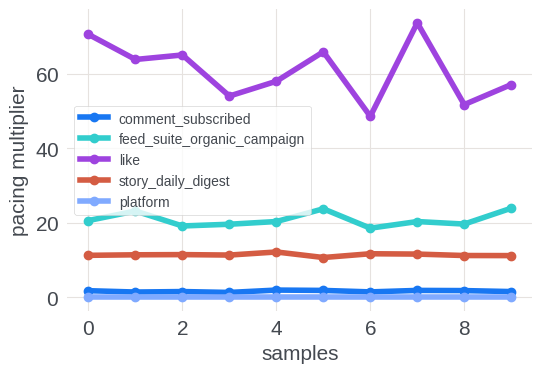

In [39]:
# plot the variation
for notification_index, (notification_type_name, _) in enumerate(dict_notification.items()):
    plt.plot(
        range(len(pacing_multipliers_samples)), 
        [betas[notification_index] for _, betas in pacing_multipliers_samples.items()], 
        '-o',
        label = notification_type_name
    )
plt.plot(
    range(len(pacing_multipliers_samples)), 
    [betas['platform'] for _, betas in pacing_multipliers_samples.items()], 
    '-o',
    label = 'platform'
)
plt.ylabel('pacing multiplier')
plt.xlabel('samples')
plt.legend()

In [40]:
# take an average across the samples for utilities and the pacing multipliers
utilities_price_learning_exp = {}
pacing_multipliers_price_learning = {}
for key in [x['index'] for _, x in dict_notification.items()] + ['platform']:
    utilities_list = np.array([
        utilities_sample[key]
        for _, utilities_sample in utilities_samples.items()
    ])

    pacing_multpliers_list = np.array([
        pacing_multipliers_sample[key] 
        for _, pacing_multipliers_sample in pacing_multipliers_samples.items()
    ])

    pacing_multipliers_price_learning[key] = np.sum(
        utilities_list*pacing_multpliers_list
    ) / np.sum(utilities_list)

    utilities_price_learning_exp[key] = np.average(utilities_list) / proportion_selected

### 2.4 compute the prices for each user

In [45]:
# calculate the price for each user
user_prices = {}
for user_id in np.unique(
    np.concatenate((
        np.array(df_simulation['user_id']), 
        np.array(df_price_learning['user_id'])
    ))
):
    user_prices[user_id] = {'paced_total_bids': [], 'price': 0}

for user_id in df_price_learning['user_id'].unique():
    notif_generated_for_user = df_price_learning[
        df_price_learning['user_id'] == user_id
    ]
    for _, row in notif_generated_for_user.iterrows():
        v_ij = row['notification_value']
        v_ijp = row['platform_value']
        notification_index = int(row['notification_index'])
        beta_i = pacing_multipliers_price_learning[notification_index]
        beta_p = pacing_multipliers_price_learning['platform']
        user_prices[user_id]['paced_total_bids'].append(
            beta_i * v_ij + beta_p * v_ijp
        )

for user_id, _ in user_prices.items():
    if len(user_prices[user_id]['paced_total_bids']) >= num_notifs_allowed:
        user_prices[user_id]['price'] = np.sort(
            user_prices[user_id]['paced_total_bids']
        )[-num_notifs_allowed]

Text(39.91334533691406, 0.5, 'price (inflated with proper scale)')

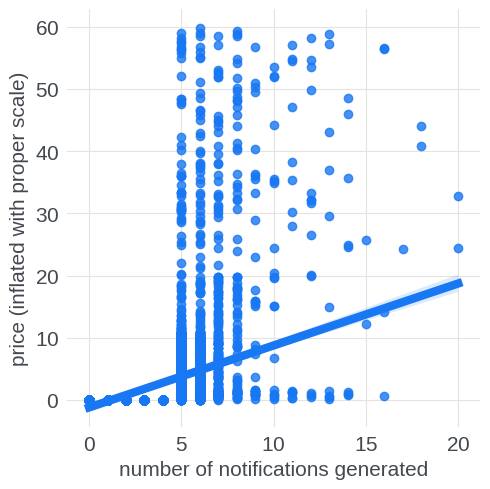

In [44]:
# plot price vs number of notifications generated
num_notifs_gen_price_learning = pd.Series([
    len(x['paced_total_bids']) for _, x in user_prices.items()
])
prices_list = pd.Series([
    x['price'] for _, x in user_prices.items()
])
sns.lmplot(
    x='num_notif',
    y='price',
    data=pd.DataFrame({
        'num_notif':num_notifs_gen_price_learning[num_notifs_gen_price_learning<=1000], 
        'price':prices_list[num_notifs_gen_price_learning<=1000]
    }),
    fit_reg=True
) 
plt.xlabel('number of notifications generated')
plt.ylabel('price (inflated with proper scale)')

## 3. Simulation - Algorithm 1 in paper

In [46]:
# keep track of utilities for each notification type
utility_so_far = {}
for notification_index in range(len(dict_notification)):
    utility_so_far[notification_index] = 0
utility_so_far['platform'] = 0

# keep track of pacing multipliers
pacing_multiplier_upper_bound_factor = 2
pacing_multipliers_upper_bound = {}
for key, val in pacing_multipliers_price_learning.items():
    pacing_multipliers_upper_bound[key] = val * pacing_multiplier_upper_bound_factor
pacing_multipliers = copy.deepcopy(pacing_multipliers_upper_bound)

# time horizon and budgets
T = df_simulation.shape[0]
budget_notification_types_simulation = np.array(
    [notification_type['budget_simulation'] for _, notification_type in dict_notification.items()]
) 

# keep track of notifications that win the auction for each user
bid_win_users = {}
for user_id in df_simulation['user_id'].unique():
    bid_win_users[user_id] = {'number':0, 'prices': []}

# prices
user_prices_simul = copy.deepcopy(user_prices)

t = 0
allocated = np.zeros(df_simulation.shape[0])
notif_pacing_multipliers = np.zeros(df_simulation.shape[0])
platf_pacing_multipliers = np.zeros(df_simulation.shape[0])
for _, row in df_simulation.iterrows():
    # compute the bid
    v_ij = row['notification_value']
    v_ijp = row['platform_value']
    user_id = row['user_id']
    notification_index = int(row['notification_index'])
    beta_i = pacing_multipliers[notification_index]
    notif_pacing_multipliers[t] = beta_i
    beta_p = pacing_multipliers['platform']
    platf_pacing_multipliers[t] = beta_p
    p_j = user_prices_simul[user_id]['price']
    bid_price = v_ij * beta_i + v_ijp * beta_p

    # if winning the auction
    if bid_price > p_j:
        allocated[t] = 1
        utility_so_far[notification_index] += v_ij
        utility_so_far['platform'] += v_ijp
        bid_win_users[user_id]['number'] += 1
        bid_win_users[user_id]['prices'].append(bid_price)
        # update price if needed
        if bid_win_users[user_id]['number'] >= num_notifs_allowed:
            user_prices_simul[user_id]['price'] = np.sort(
                bid_win_users[user_id]['prices']
            )[-(num_notifs_allowed)]
    
    # update pacing for notification types
    for notification_index in range(len(dict_notification)):
        B_i = budget_notification_types_simulation[notification_index]
        if  utility_so_far[notification_index] > 0:
            pacing_multipliers[notification_index] = min(
                pacing_multipliers_upper_bound[notification_index],
                B_i / (T * utility_so_far[notification_index] / (t+1) )
            )

    # update pacing for platforms
    if utility_so_far['platform'] > 0:
        B_p = 0
        pacing_multipliers['platform'] = min(
            pacing_multipliers_upper_bound['platform'],
            B_p / (T * utility_so_far['platform'] / (t+1))
        )

    t += 1


In [48]:
# saving the simulation results
df_simulation['sim_notif_win'] = allocated
df_simulation['notif_type_pacing_multiplier'] = notif_pacing_multipliers
df_simulation['platform_pacing_multiplier'] = platf_pacing_multipliers

df_simulation_final = df_simulation[[
    'auction_event_date', 'auction_event_time', 'event_id', 'user_id', 'notification_type', 'notification_value', 'notif_type_pacing_multiplier', 'sim_notif_win'
]]

df_simulation_final.to_csv('simulation_outcome.csv', index=False)